In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
abs_path = "/content/drive/MyDrive/atml"
sys.path.append(abs_path+"/models")
sys.path.append(abs_path+"/train")
sys.path.append(abs_path+"/datasets")

In [3]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [4]:
from datasets import train_test_random_split, load_dsprites
from train import train_control_vae, test_control_vae
from loss import loss_control_vae
from control_vae import ControlVAEDSprites

In [5]:
dataset = load_dsprites(abs_path + "/datasets/dsprites.npz")

In [6]:
dataset = torch.from_numpy(dataset)

In [7]:
n_imgs = 50000
#indices = torch.randperm(dataset.size(0))[:n_imgs]
indices = torch.randperm(dataset.size(0))
dataset = dataset[indices]

In [8]:
data_train, data_test = train_test_random_split(dataset, 0.8)

In [9]:
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [10]:
beta_controller_args = {
    'C' : 0.5,
    'C_max' : 12,
    'C_step_val' : 0.15,
    'C_step_period' : 5000,
    'Kp' : 0.01,
    'Ki' : -0.001,
    'Kd' : 0.0
}

In [11]:
model = ControlVAEDSprites(beta_controller_args)
model.to(device)

ControlVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [12]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)

In [13]:
train_control_vae(model, 50, train_loader, optimizer, 'bernoulli', device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 finished, loss: 51.039859284543326, recon loss: 42.075941978850295, kl div: 1.5052419038953404
Epoch 1 finished, loss: 40.426936610705326, recon loss: 27.741004459145998, kl div: 1.1334541232790798
Epoch 2 finished, loss: 40.03611525106761, recon loss: 25.775121537347633, kl div: 1.1310909549033061
Epoch 3 finished, loss: 38.15478994117843, recon loss: 24.72605618668927, kl div: 1.1613084585793938
Epoch 4 finished, loss: 33.99215462741753, recon loss: 23.359489323364365, kl div: 1.2518262639512412
Epoch 5 finished, loss: 27.738934266070526, recon loss: 21.715898285516435, kl div: 1.4569182039057422
Epoch 6 finished, loss: 22.423146550647086, recon loss: 20.401664518440764, kl div: 1.8120593864134409
Epoch 7 finished, loss: 21.60484103879167, recon loss: 19.695920265797113, kl div: 1.908920792539397
Epoch 8 finished, loss: 20.965379047311014, recon loss: 18.99220214597881, kl div: 1.973176920100943
Epoch 9 finished, loss: 20.231886236721444, recon loss: 18.18957485186143, kl div

NameError: ignored

In [ ]:
test_control_vae(model, test_loader, 'bernoulli', device = device)

In [14]:
torch.save(model, '/content/drive/MyDrive/atml/controlvae_epoch500_lr1e2_Cmax12.dat')

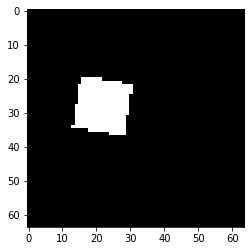

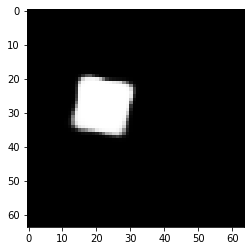

In [15]:
model = torch.load('/content/drive/MyDrive/atml/controlvae_epoch500_lr1e2_Cmax12.dat')
index = 100
original = dataset[index].float().to(device)
recon, mu, logvar = model(original)
plt.imshow(original.cpu(), cmap='Greys_r')
plt.show()
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

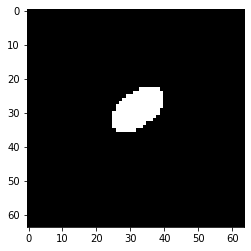

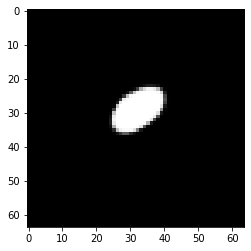

In [18]:
index = 198964
original = dataset[index].float().to(device)
recon, mu, logvar = model(original)
plt.imshow(original.cpu(), cmap='Greys_r')
plt.show()
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()